*Antonio Coín Castro*

# Functional Methods in Machine Learning

Final exam    
Due date: Tuesday, 2021/03/09, 18:00

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

from sklearn import datasets, svm
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.kernel_approximation import Nystroem, RBFSampler

import stochastic_plots as stoch
import kernel_machine_learning as kml
import kernel_approximation as ka

%load_ext autoreload
%autoreload 2

seed = 0
np.random.seed(seed)

## The exponential kernel

### Generation of random samples: inverse transform sampling

Consider a real-valued random variable whose pdf is $f(x)$. The corresponding cdf is

$$
F(x) = \int_{-\infty}^{x} dx'\, f(x').
$$

The inverse of the cdf ($F^{-1}(p)$) can be used to generate random numbers from this distribution using the following algorithm:

1. Generate a sample from the $U[0,1]$ distribution $\left\{u_m \right\}_{m=1}^M$, with $u_m \sim U[0,1]$.
2. The sample $\left\{w_m = F^{-1}(u_m) \right\}_{m=1}^M$ is such that $w_m \sim f(w)$. 

---

For instance, the pdf of an exponential distribution defined on the set of non-negative real numbers is

$$
f(x) = \lambda e^{-\lambda x},   x \ge 0,
$$

with $\lambda > 0$. An alternative parametrization arises if we consider $\gamma=\lambda^{-1}$.

The corresponding cdf is

$$
F(x) = \int_{0}^{x} dx \, \lambda e^{-\lambda x} = 1 - e^{-\lambda x}, \  x \ge 0.
$$

The inverse of the cdf is such that $F^{-1}(p) = x$. Since 

$$p = F(x) = 1 -e^{-\lambda x} \implies x = - \log (1-p) / \lambda,
$$

we have:

$$
F^{-1}(p) = -\frac{1}{\lambda} \log (1-p), \ 0 \le p < 1.
$$

See, for instance, [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution). We proceed to illustrate this method by generating samples of the exponential distribution.

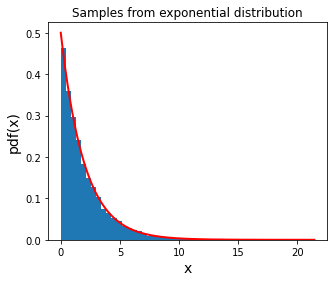

In [16]:
# Exponential distribution (gamma = 1/lambda)

def exp_pdf(x, gamma):
    return np.exp(-x/gamma)/gamma


def exp_cdf(x, gamma):
    return 1.0 - np.exp(-x/gamma)


def exp_inverse_cdf(p, gamma):
    return -gamma*np.log(1.0 - p)


# Inverse transform sampling

gamma = 2.0
n_samples = 10000

U = np.random.rand(n_samples)  # U ~ U[0, 1]
X = exp_inverse_cdf(U, gamma)

# Plot histogram vs pdf

_ = stoch.plot_pdf(
    X,
    lambda x: exp_pdf(x, gamma),
    fontsize=14,
    fig_size=(5, 4),
    fig_num=1,
)
plt.title("Samples from exponential distribution")
plt.show()

### Exponential kernel in 1 dimension

The exponential kernel in 1 dimension is the shift-invariant kernel

$$
k(x, x') = k(x - x') = \exp\left(- \frac{\left|x - x' \right|}{\gamma}\right).
$$

By Bochner's theorem, we know that this kernel is the Fourier transform of a certain pdf:

$$
k(x) = \int_{-\infty}^{\infty} e^{i \omega x} \text{pdf}(\omega) \, d\omega.
$$

Thus, the unknown density is proportional to the inverse Fourier transform of $k(x)$:

$$
\hbox{pdf}(\omega) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i \omega x} k(x)\, dx.
$$

####  Q1. Express the 1-D exponential kernel as the Fourier transform of a density pdf$\boldsymbol{(\omega)}$.

Let $\gamma>0$ and let $k(x)=e^{-|x|/\gamma}$ for $x\in \mathbb R$. As an initial comment, we note that the implied pdf must already be normalized, since

$$
\int_{-\infty}^\infty \text{pdf}({\omega})\, d\omega = k(0)=e^{0}=1.
$$

On the other hand, we have:

\begin{align*}
\text{pdf}(\omega) &= \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i \omega x} k(x)\, dx\\
&= \frac{1}{2 \pi} \int_{-\infty}^{0} e^{-x(i\omega - 1/\gamma)}\, dx + \frac{1}{2 \pi} \int_{0}^{\infty}e^{-x(i\omega + 1/\gamma)}\, dx \\
&=\frac{1}{2\pi}\left\{ \left[ -\frac{e^{-x(i\omega - 1/\gamma)}}{i\omega - 1/\gamma} \right]_{-\infty}^0  + \left[ -\frac{e^{-x(i\omega + 1/\gamma)}}{i\omega + 1/\gamma} \right]_{0}^\infty \right\}\\
&= \frac{1}{2\pi}\left(\frac{-1}{i\omega - 1/\gamma} + \lim_{x\to-\infty} \frac{e^{-i\omega x}e^{x/\gamma}}{i\omega - 1/\gamma} - \lim_{x\to\infty} \frac{e^{-i\omega x}e^{-x/\gamma}}{i\omega + 1/\gamma} + \frac{1}{i\omega + 1/\gamma}\right)\\
&\stackrel{(\ast)}{=} \frac{1}{2\pi}\left( \frac{-1}{i\omega - 1/\gamma} +\frac{1}{i\omega + 1/\gamma}\right)\\
&= \frac{1}{2\pi}\left( \frac{-2}{-\gamma\omega^2 - 1/\gamma} \right)\\
&= \frac{\gamma}{\pi} \frac{1}{(\gamma\omega)^2 + 1}, \quad \omega \in \mathbb R,
\end{align*}

where in $(\ast)$ we have used that $e^{-i\omega x}$ is bounded and thus, since $\gamma>0$, we have $e^{-i\omega x}e^{\pm x1/\gamma}\to 0$ as $x\to\mp\infty$.

Given this, we can express the exponential kernel as the Fourier transform of the density pdf$(\omega)$:

$$
k(x, x')=k(x-x') =  \int_{-\infty}^\infty e^{i\omega(x - x')}\frac{\gamma}{\pi}\frac{1}{(\gamma\omega)^2 + 1} \, d\omega.
$$

####  Q2. Derive the cdf and inverse of the cdf for this pdf$\boldsymbol{(\omega)}$.              


First of all we need to compute the cdf associated with the distribution found in the previous question, which turns out to be an immediate integral:

$$
F(\omega)=\int_{-\infty}^\omega \text{pdf}(x)\, dx=\frac{\gamma}{\pi}\int_{-\infty}^\omega \frac{dx}{(\gamma x)^2 + 1}=\frac{1}{\pi}\big[ \arctan(\gamma x) \big]_{-\infty}^\omega= \frac{1}{\pi}\arctan(\gamma \omega) + \frac{1}{2}, \quad \omega \in \mathbb R.
$$

Then we proceed to calculate the inverse of the cdf function:

$$
F^{-1}(p)=\frac{1}{\gamma} \tan\left(\pi \left(p- \frac{1}{2}\right)\right), \quad 0 < p < 1.
$$

#### Q3. Use the method of the inverse to generate random numbers sampled from pdf$\boldsymbol{(\omega)}$.

Note that the values $p=0,1$ are not allowed in $F^{-1}(p)$, since the function $\tan$ is undefined in $\pm \frac{\pi}{2}$. However, when we apply the method of the inverse we still generate random values using the distribution $U[0,1]$, since $P_{U}(U=0)=P_{U}(U=1)=0$. 

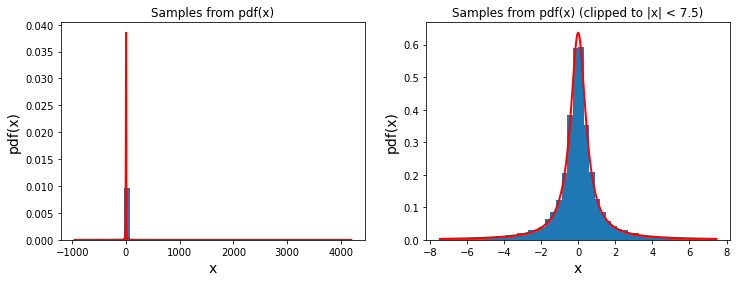

In [17]:
# Distribution given by pdf(x)
# (i.e inverse Fourier transform of exponential kernel)

def exp_kernel_pdf(x, gamma):
    return gamma/(np.pi*((gamma*x)**2 + 1))


def exp_kernel_cdf(x, gamma):
    return np.atan(gamma*x)/np.pi + 0.5


def exp_kernel_inverse_cdf(p, gamma):
    return np.tan(np.pi*(p - 0.5))/gamma


# Inverse transform sampling

gamma = 2.0
n_samples = 10000

U = np.random.rand(n_samples)  # U ~ U[0, 1]
X = exp_kernel_inverse_cdf(U, gamma)

# Plot histogram vs pdf

_, axs = plt.subplots(1, 2, num=2, figsize=(12, 4))

_ = stoch.plot_pdf(
    X,
    lambda x: exp_kernel_pdf(x, gamma),
    ax=axs[0],
    fontsize=14,
)

# Truncate x-axis to improve visualization

threshold = 7.5
X_clipped = X[np.abs(X) < threshold]

_ = stoch.plot_pdf(
    X_clipped,
    lambda x: exp_kernel_pdf(x, gamma),
    ax=axs[1],
    fontsize=14,
)

axs[0].set_title("Samples from pdf(x)")
axs[1].set_title(f"Samples from pdf(x) (clipped to |x| < {threshold})")
plt.show()

In the leftmost plot, we observe that there are fairly big outliers and the scale is distorted. This phenomenon was to be expected, since $\tan(x)\to\infty$ as $x\to \frac{\pi}{2}^-$ and $\tan(x)\to -\infty$ as $x\to -\frac{\pi}{2}^+$. We can try to restrict a bit the extreme values when visualizing the histogram, and as we see in rightmost plot, the approximation is good.

### Exponential kernel in $D$ dimensions

Consider the exponential kernel in $D\geq 1$ dimensions

$$ 
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}- \mathbf{x}') = \exp\left(- \frac{\lVert \mathbf{x}- \mathbf{x}' \rVert_1}{\gamma} \right),
$$

where $\gamma>0$ and the $L_1$ norm is defined as

$$ 
\lVert \mathbf{x}- \mathbf{x}' \rVert_1 = \sum_{d=1}^D \left|x_d \right|.
$$

The inverse Fourier transform of the exponential kernel in $D$ dimensions is proportional to a pdf:

$$
\text{pdf}(\mathbf{w}) \propto \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left(- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right)\, d \mathbf{x}.
$$

#### Q4. Compute the inverse Fourier transform of the exponential kernel in $D$ dimensions.

We know that inverse Fourier transform of a translationally invariant kernel

$$
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x} - \mathbf{x}')
$$

is given by

$$
\text{pdf}(\mathbf{w}) = \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) \, d\mathbf{x}.
$$

In our case, if $\mathbf w=(\omega_1,\dots, \omega_D)$ and $\mathbf x=(x_1,\dots, x_D)$, we have:

\begin{align*}
\text{pdf}(\mathbf w) &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb R^D} \exp(-i \mathbf{w}^T \mathbf{x})\exp\left(\frac{-\lVert \mathbf{x} \rVert_1}{\gamma}\right) \, d \mathbf{x}\\
&= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb R^D} \exp\left(-\sum_{d=1}^D i\omega_dx_d+ \frac{|x_d|}{\gamma} \right) \, d\mathbf x\\
&= \prod_{d=1}^D \frac{1}{2\pi}\int_{-\infty}^{\infty} \exp(-i\omega_dx_d)\exp(-|x_d|/\gamma)\, dx_d\\
&= \prod_{d=1}^D \text{pdf}(\omega_d),
\end{align*}

where pdf$(\omega)$ is the inverse Fourier transform of the 1-D exponential kernel, computed in the previous question. This pdf is already normalized, since each of the 1-D pdfs is normalized.

#### Q5. Use the method of the inverse to generate random numbers sampled from pdf$(\mathbf{x})$.

We have seen that joint pdf associated with the $D$-dimensional exponential kernel factorizes as the product of the corresponding one-dimensional pdfs. For this reason and recalling the properties of the integral, the cdf necessarily factorizes as well, that is,

$$
F(\mathbf x)=\prod_{d=1}^D F(x_d), \quad \mathbf x=(x_1,\dots, x_d)\in \mathbb R^D.
$$

Given this, the inverse of the multidimensional cdf is straightforward to compute. Indeed, for $\mathbf p=(p_1,\dots, p_D) \in (0,1)^D$ we have:

$$
F^{-1}(\mathbf p)= \left( F^{-1}(p_1), \dots, F^{-1}(p_D)\right) =  \frac{1}{\gamma} \left( \tan\left(\pi \left(p_1- 1/2\right)\right), \dots, \tan\left(\pi \left(p_D- 1/2\right)\right) \right).
$$

For implementing the method of the inverse to sample from this multidimensional distribution, we use the vectorized function we had for the one-dimensional exponential kernel. We provide an example below of the 2-D case.

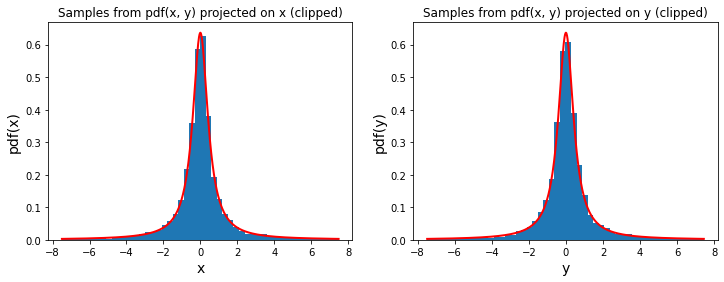

In [18]:
# Inverse transform sampling

D = 2
gamma = 2.0
n_samples = 10000

U = np.random.rand(n_samples, D)  # U ~ U([0, 1]^D)
X = exp_kernel_inverse_cdf(U, gamma)

# Plot histogram vs pdf on each dimension

_, axs = plt.subplots(1, 2, num=3, figsize=(12, 4))

threshold = 7.5
mask = np.array(np.abs(X) < threshold).all(axis=1)
X_clipped = X[mask].T

_ = stoch.plot_pdf(
    X_clipped[0],
    lambda x: exp_kernel_pdf(x, gamma),
    ax=axs[0],
    fontsize=14,
)

_ = stoch.plot_pdf(
    X_clipped[1],
    lambda x: exp_kernel_pdf(x, gamma),
    ax=axs[1],
    fontsize=14,
)

axs[0].set_title(
    f"Samples from pdf(x, y) projected on x (clipped)")
axs[1].set_title(
    f"Samples from pdf(x, y) projected on y (clipped)")
axs[1].set_ylabel("pdf(y)")
axs[1].set_xlabel("y")
plt.show()

In order to visualize the histogram of samples, we make two plots of the samples projected on each component, clipped to $\lVert (x, y)\rVert<7.5$. We could also try to make a 2-D histogram of sorts, visualizing a heat map of the samples, as well as the contour plot of the theoretical 2-D pdf.

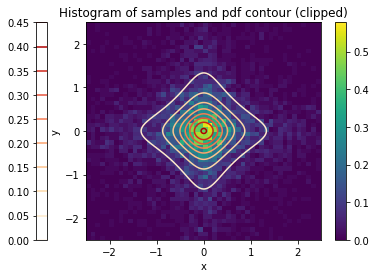

In [19]:
def exp_kernel_pdf_2d(x, y, gamma):
    return exp_kernel_pdf(x, gamma)*exp_kernel_pdf(y, gamma)


# Generate a 2-D grid and evaluate the pdf on it

n_samples = 1000
threshold = 2.5
x = np.linspace(-threshold, threshold, n_samples)
xx, yy = np.meshgrid(x, x)
z = exp_kernel_pdf_2d(xx, yy, gamma)

# Contour plot of pdf and 2-D histogram of values

_, ax = plt.subplots(1, 1, num=4, figsize=(7, 4))
plt.title("Histogram of samples and pdf contour (clipped)")
plt.xlabel("x")
plt.ylabel("y")

mask = np.array(np.abs(X) < threshold).all(axis=1)
X_clipped = X[mask].T
h = ax.hist2d(
    X_clipped[0],
    X_clipped[1],
    bins=50,
    density=True
)
c = ax.contour(xx, yy, z, cmap="OrRd", levels=8)
plt.colorbar(c, ax=[ax], location='left')
plt.colorbar(h[3], ax=[ax], location='right')
plt.show()

Finally, we can visualize the surface plot of the two-dimensional theoretical pdf:

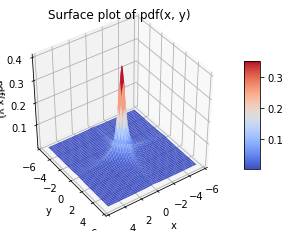

In [20]:
threshold = 5.5
x = np.linspace(-threshold, threshold, n_samples)
xx, yy = np.meshgrid(x, x)
z = exp_kernel_pdf_2d(xx, yy, gamma)

# Surface plot
fig = plt.figure(figsize=(5, 4), num=5)
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, z, cmap='coolwarm')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('pdf(x,y)')
ax.set_title('Surface plot of pdf(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=7)
ax.view_init(40, 55)

#### Q6. Write code to generate Random Fourier Features corresponding to the exponential kernel in D dimensions.          


The code implemented is encapsulated in the class

```python
class RandomFeaturesSamplerExp(RandomFeaturesSampler)
```
in the file `kernel_approximation.py`.

## Generation of Random Fourier Features: alternative sampling scheme

Consider the translationally invariant kernel $k\left(\mathbf{x}, \mathbf{x}'\right) = k\left(\mathbf{x} - \mathbf{x}'\right)$, with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$.

According to Bochner's theorem, this type of kernel can be expressed as the Fourier transform of a (possibly not normalized) density $p(\mathbf{w})$:

$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{\mathbb R^D} d\mathbf{w} \, p\left(\mathbf{w}\right) e^{i \mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right)}.
$$

Since the kernel function is real and symmetric, this expression can be written as 

$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{\mathbb R^D} d\mathbf{w}\, p\left(\mathbf{w}\right) \cos \left(\mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right) \right).
$$

We will show that the set of random features

$$
\left\{ \Phi^{(1)}_{\mathbf w}(\mathbf x)=\left( \cos \mathbf{w}^T \mathbf{x}, \sin \mathbf{w}^T \mathbf{x} \right)^T; \ \mathbf{w} \sim p(\mathbf{w})\right\}
$$

and the set 

$$
\left\{\Phi^{(2)}_{\mathbf w,b}(\mathbf x) = \sqrt{2} \cos \left(\mathbf{w}^T \mathbf{x} + b \right); \ \mathbf{w} \sim p(\mathbf{w}); \ b \sim U[0 , 2\pi]; \ \mathbf{w} \perp b\right\}
$$

provide the same approximation of the kernel. That is, if we consider either of the random features $\Phi(\mathbf x)$, we will prove that

$$
k(\mathbf x - \mathbf x') = \mathbb E\left[ \left(\Phi(\mathbf x)\right)^T\Phi(\mathbf x')\right].
$$

For a more detailed account and error analysis, see (Rahimi and Recht, 2007).

---

On the one hand, the kernel approximation using the first type of features is:

\begin{align*}
\mathbb E_{\mathbf w}\left[ \left(\Phi^{(1)}_{\mathbf w}(\mathbf x)\right)^T\Phi^{(1)}_{\mathbf w}(\mathbf x')\right] &=\int_{\mathbb R^D} d\mathbf{w}\, p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}, \, \sin \mathbf{w}^T \mathbf{x} \right) \left( \cos \mathbf{w}^T \mathbf{x}', \, \sin \mathbf{w}^T \mathbf{x}' \right)^T\\ 
&=\int_{\mathbb R^D} d\mathbf{w}\, p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}  \, \cos \mathbf{w}^T \mathbf{x}' + \sin \mathbf{w}^T \mathbf{x} \,  \sin \mathbf{w}^T \mathbf{x}' \right) \\
 &\stackrel{(\ast)}{=}\int_{\mathbb R^D}d\mathbf{w}\, p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right)\\
&= k\left(\mathbf{x}- \mathbf{x}'\right),
\end{align*}

where in $(\ast)$ we applied the sum of angles identity, i.e.:

$$
\cos(\alpha\pm \beta) = \cos(\alpha)\cos(\beta) \mp \sin(\alpha)\sin(\beta).
$$

#### Q7. Derive the kernel approximation using the second type of features.              


For the second type of features, we have

$$
\left(\Phi^{(2)}_{\mathbf w,b}(\mathbf x)\right)^T\Phi^{(2)}_{\mathbf w,b}(\mathbf x') = 2 \cos(\mathbf w^T \mathbf x + b)\cos(\mathbf w^T \mathbf x' + b)\stackrel{(\ast)}{=} \cos(\mathbf w^T(\mathbf x + \mathbf x') + 2b) + \cos(\mathbf w^T(\mathbf x - \mathbf x')),
$$

where in $(\ast)$ we have used the cosine product formula:

$$
2\cos\alpha\cos\beta = \cos(\alpha+\beta) + \cos(\alpha-\beta).
$$

Now, taking expectations in the above expression and using the linearity of the integral and Fubini's theorem, we arrive at the desired conclusion:

\begin{align*}
\mathbb E_{\mathbf w,b} \left[  \left(\Phi^{(2)}_{\mathbf w,b}(\mathbf x)\right)^T\Phi^{(2)}_{\mathbf w,b}(\mathbf x') \right] &= \mathbb E_{\mathbf w,b} \left[\cos(\mathbf w^T(\mathbf x + \mathbf x') + 2b)\right] + \mathbb E_{\mathbf w,b} \left[\cos(\mathbf w^T(\mathbf x - \mathbf x'))\right]\\
&= \mathbb E_{\mathbf w}\left[ \mathbb E_b \left[ \cos(\mathbf w^T(\mathbf x + \mathbf x') + 2b)\right]\right] + \mathbb E_{\mathbf w} \left[\cos(\mathbf w^T(\mathbf x - \mathbf x'))\right]\\
&\stackrel{(\dagger)}{=} 0 + \int_{\mathbb R^D} d\mathbf w\, p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right)\\
&= k(\mathbf x, \mathbf x').
\end{align*}

The first term in $(\dagger)$ vanishes because the inner expectation amounts to the average of the cosine function from $\mathbf w^T(\mathbf x + \mathbf x')$ to $\mathbf w^T(\mathbf x + \mathbf x') + 4\pi$ (since $b$ is uniform in $[0,2\pi]$), that is, the average over two complete periods. This quantity is $0$ because the average value of the cosine over every period of length $2\pi$ is $0$. Alternatively, we could compute the integral to convince ourselves:

$$
\mathbb E_b \left[ \cos(\mathbf w^T(\mathbf x + \mathbf x') + 2b)\right] = \frac{1}{2\pi}\int_0^{2\pi} db \, \cos(\mathbf w^T(\mathbf x + \mathbf x') + 2b) = \frac{1}{4\pi}\left[ \sin(\mathbf w^T(\mathbf x + \mathbf x') + 2b)\right]_0^{2\pi}=0.
$$

#### Q8. Implement the sampling method based on the second type of random features.

The corresponding code is available in the file `kernel_approximation.py`, specifically in the `fit` method of the class
```python
class RandomFeaturesSampler(BaseEstimator, TransformerMixin)
```

The idea is to approximate the expected value computed in the previous question via a Monte Carlo sampling scheme:

- **Step 1:** sample independently $\{\mathbf w_j \sim p(\mathbf w); \ j=1,\dots, J\}$ and $\{b_j \sim U[0, 2\pi]; \ j=1,\dots, J\}$.
- **Step 2:** compute $J$ random features for each training example $\mathbf x$ as
$$
\{\hat\Phi_{\mathbf w_j, b_j}(\mathbf x)=\cos(\mathbf w_j^T \mathbf x + b_j); \ j=1,\dots, J\}.
$$
- **Step 3:** multiply each feature vector by the normalization factor $\sqrt{\frac{2}{J}}$.

Following this algorithm, we obtain the following approximation:

\begin{align*}
k(\mathbf x, \mathbf x')&=\mathbb E_{\mathbf w, b}\left[\left(\Phi^{(2)}_{\mathbf w, b}(\mathbf x)\right)^T\Phi^{(2)}_{\mathbf w,b}(\mathbf x') \right] \\
&\approx \frac{1}{J}\sum_{j=1}^J\left(\Phi^{(2)}_{\mathbf w_j, b_j}(\mathbf x)\right)^T\Phi^{(2)}_{\mathbf w_j,b_j}(\mathbf x')\\
&= \sum_{j=1}^J \left(\sqrt{\frac{2}{J}}\hat\Phi_{\mathbf w_j, b_j}(\mathbf x)\right)  \left( \sqrt{\frac{2}{J}}\hat\Phi_{\mathbf w_j, b_j}(\mathbf x')\right) \stackrel{J\to\infty}{\longrightarrow} k(\mathbf x, \mathbf x').
\end{align*}

#### Q9. Illustrate that both types of feaures approximate the exponential kernel when $p(\mathbf{w})$ is the inverse Fourier transform of the exponential kernel in $D$ dimensions.        

We generate a toy 3-D dataset to test the approximation with the different types of features.

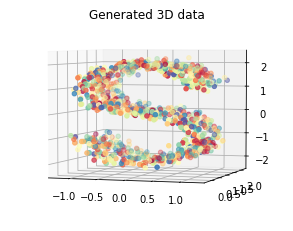

In [21]:
# Generate 3D data
n_instances = 1000
X, t = datasets.make_s_curve(
    n_instances, noise=0.1, random_state=seed
)
X = X[np.argsort(t)]

# Visualize dataset
fig = plt.figure(figsize=(5, 4), num=6)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
ax.set_title("Generated 3D data")
plt.show()

Features of type I:


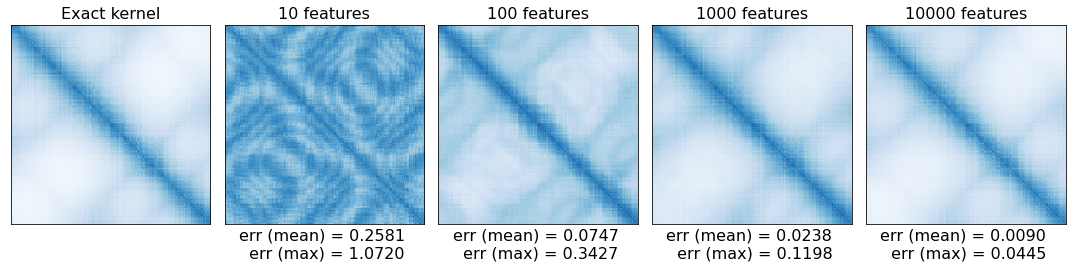

Features of type II:


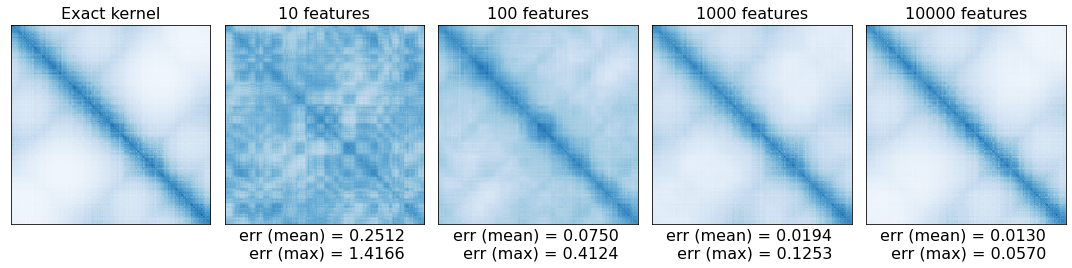

In [29]:
# Approximate the exponential kernel using Random Fourier Features

length_scale = 2.0

def kernel(X, Y):
    return kml.exponential_kernel(X, Y, A=1.0, ls=length_scale)


# Features of type I
exp_sampler_1 = ka.RandomFeaturesSamplerExp(
    sampling_method='sin+cos',
    length_scale_kernel=length_scale,
    random_state=seed
)

# Features of type II
exp_sampler_2 = ka.RandomFeaturesSamplerExp(
    sampling_method='cos',
    length_scale_kernel=length_scale,
    random_state=seed
)

# Plot the approximations to the kernel matrix

n_random_features = [10, 100, 1000, 10000]

print("Features of type I:")
ka.demo_kernel_approximation_features(
    X,
    kernel,
    exp_sampler_1,
    n_random_features,
    fig_num=7
)

print("Features of type II:")
ka.demo_kernel_approximation_features(
    X,
    kernel,
    exp_sampler_2,
    n_random_features,
    fig_num=8
)

As we can see, both types of features provide a good approximation, decreasing the mean and max error as we increase the number of random features.

## Train and evaluate different classifiers

In this section we will use the same data as in [this sklearn example](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py).

**Q10. Using 5-fold cross validation on the training data, determine the optimal values of the hyperparameter for the following cases:**

**1. Non-linear SVM + RBF kernel [C, gamma].**     
**2. Linear SVM + RBF Random features [C, gamma, n_features].**       
**3. Linear SVM + RBF Nyström features [C, gamma, n_features].**       
**4. Non-linear SVM + exponential kernel [C, length_scale].**       
**5. Linear SVM + exponential Random features [C, length_scale, n_features].**        
**6. Linear SVM + exponential Nyström features [C, length_scale, n_features].**

**To get more stable results, the process should be repeated for 10 different random train / test partitions of the data.**

Below we summarize the process step by step.

### Methodology outline

When it comes to separating the original dataset into training and test partitions, we follow the same scheme as the sklearn example linked above: we use 50% of the data for training, and the remaining 50% for testing. However, in opposition to what is done in the example, we make the partitions random, preserving the proportion of class labels (*stratified split*).
 
To find the optimal hyperparameters, we perform a grid search using cross-validation on $5$ folds in the training set. Then, we proceed to refit the optimal classifier in the whole training set, and then we evaluate it on the test set. We also take some statistical measures such as the mean cross validation error across folds or the mean fitting time. It should be noted that we repeat the whole process 10 times (randomly dividing the data into train/test and then performing cross-validation) to increase the robustness and stability of the computations. After this is done, we average the results of the 10 runs for subsequent analysis.

### Hyperparameter grid

To select the search space for the hyperparameters we follow the two-step approach recommended in (Hsu, Chang and Lin, 2003), which is the following:

- First, select a coarse grid for each hyperparameter and perform cross-validation to select the best ones.

- Then, refine the grid for each parameter using a smaller neighbourhood of the optimal value found. For example, if the optimal value is $c^\ast$, we construct the search grid $\{c^\ast/4, c^\ast/2, c^\ast, 2c^\ast, 4c^\ast\}$.

For the first step, we perform only one iterarion of the main loop (one train/test division), because it is only an approximated starting point. In order to find the coarse grid for each hyperparameter, we apply some of the methods found in the literature. Specifically:

- For the parameter `n_features` in Random Features, the main reference is (Rahimi and Recht, 2007), where the authors prove a probabilistic bound that shows that the error decreases exponentially with the number of features. For this reason, we deem that the approximation will be sufficiently good even for a low number of features sampled, so we set a grid of $\{25, 100, 200, 300, 400\}$. The reasoning in the case of Nyström features is similar, and we can find analogous bounds for example in (Chang et al., 2013). This approach is supported for instance in (Yang et al., 2012), where a relatively low value of `n_features` is used in both methods, even for large datasets. We also use the same grid for both methods to be able to compare them.

- For setting the regularization parameter`C`, we mimic the method used in (Nguyen et al., 2017), which in turn is also a modification of the recommendation in (Hsu, Chang and Lin, 2003). Specifically, we use $\{2^{-5}/M, \dots, 2^{15}/M\}$ as the initial logarithmic grid, where $M$ is the number of samples used for training. In addition, we reproduce [sklearn's behaviour](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and add the value `'auto'` to the grid, which is equal to `1/n_features`.

- For the kernel hyperparameters `gamma` and `length_scale`, we follow the recommendation in (Hsu, Chang and Lin, 2003) and use the exponentially growing sequence $\{2^{-15}, \dots, 2^{3}\}$. Depending of the concrete parametrization of the kernel, we might have to consider the inverse of each element (specifically, we must do so for our implementation of the Exponential Random Features).

We set an initial space of $5$ values for `n_features` and $10$ values for `C`, `gamma` and `lenght_scale`; then in the finer grid we shrink the second space to $5$ values. We have found that these values are sufficient to illustrate the performance of the different models within a reasonable time budget.

### Grid search

We begin by loading and preprocessing the data. We first scale the data to $[0,1]$ and then center it by subtracting the mean.

Shape of data matrix: (1617, 64)


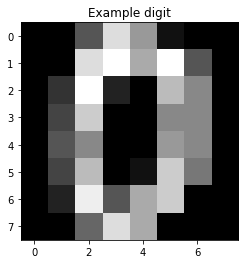

In [5]:
# Load and normalize data
digits = datasets.load_digits(n_class=9)
data = digits.data/16.
data -= data.mean(axis=0)
target = digits.target

n_samples, n_features = data.shape
print("Shape of data matrix:", data.shape)

# Show example digit
fig = plt.figure(figsize=(5, 4), num=9)
plt.imshow(digits.images[0], cmap='gray')
plt.title("Example digit")
_ = plt.show()

In this case we use sklearn's transformers `RBFSampler` and `Nystroem`. For classification purposes we use non-linear `SVC` and `LinearSVC`. Since in our case `n_samples`$ > $`n_features`, we set `dual=False` in the `LinearSVC` classifier as recommended in [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [6]:
# Build a Pipeline for each classifier

models = [
    # Non-linear RBF SVM
    (Pipeline([("svc_sk_rbf",
                svm.SVC(kernel='rbf', random_state=seed))]),
     "SVM with RBF kernel"),
    # RBF Random Features + Linear SVM
    (Pipeline([("rbf_features",
                RBFSampler(random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(random_state=seed, dual=False))]),
     "RBF Random Features + Linear SVM"),
    # RBF Nyström Features + Linear SVM
    (Pipeline([("nystroem_rbf_features",
                Nystroem(kernel='rbf', random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(random_state=seed, dual=False))]),
     "RBF Nyström Features + Linear SVM"),
    # Non-linear exponential SVM
    (Pipeline([("svc_sk_exp",
                svm.SVC(kernel=PairwiseKernel(metric='laplacian'),
                        random_state=seed))]),
     "SVM with exponential kernel"),
    # Exponential Random Features (our implementation) + Linear SVM
    (Pipeline([("exp_features",
                ka.RandomFeaturesSamplerExp(random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(random_state=seed, dual=False))]),
     "Exponential Random Features (our implementation) + Linear SVM"),
    # Exponential Nyström Features + Linear SVM
    (Pipeline([("nystroem_exp_features",
                Nystroem(kernel='laplacian', random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(random_state=seed, dual=False))]),
     "Exponential Nyström Features + Linear SVM"),
]

# Set parameter search space

n_features_space = [25, 100, 200, 300, 400]
coarse_C_space = np.append(
    np.logspace(-5, 15, 9, base=2.0)/(n_samples/2.),
    1./n_features
)
coarse_scale_space = np.logspace(-15, 3, 10, base=2.0)

parameters = [
    # Non-linear RBF SVM
    {"svc_sk_rbf__C": coarse_C_space,
     "svc_sk_rbf__gamma": coarse_scale_space
     },
    # RBF Random Features + Linear SVM
    {"svc_sk__C": coarse_C_space,
     "rbf_features__gamma": coarse_scale_space,
     "rbf_features__n_components": n_features_space
     },
    # RBF Nyström Features + Linear SVM
    {"svc_sk__C": coarse_C_space,
     "nystroem_rbf_features__n_components": n_features_space,
     "nystroem_rbf_features__gamma": coarse_scale_space
     },
    # Non-linear exponential SVM
    {"svc_sk_exp__C": coarse_C_space,
     "svc_sk_exp__kernel__gamma": coarse_scale_space
     },
    # Exponential Random Features (our implementation) + Linear SVM
    {"svc_sk__C": coarse_C_space,
     "exp_features__length_scale_kernel": 1./coarse_scale_space,
     "exp_features__n_components": n_features_space
     },
    # Exponential Nyström Features + Linear SVM
    {"svc_sk__C": coarse_C_space,
     "nystroem_exp_features__n_components": n_features_space,
     "nystroem_exp_features__gamma": coarse_scale_space
     }
]

The cross-validation and hyperparameter tuning process is implemented in the function `demo_cv_search` in the file `kernel_approximation.py`. As we explained before, we first conduct a search on a coarse grid to capture the ranges of hyperparameters that best suit our data.

In [ ]:
# Perform cross validation with a coarse grid
_ = ka.demo_cv_search(
    data,
    target,
    models,
    parameters,
    n_train=0.5,
    n_folds=5,
    n_runs=1,
    verbose=True,
    seed=seed
)

-- SVM with RBF kernel --
  Grid search time: 86.208s
  Test score: 0.990
  Best parameters:
 {'svc_sk_rbf__C': 7.164649043265551, 'svc_sk_rbf__gamma': 0.125}

-- RBF Random Features + Linear SVM --
  Grid search time: 330.090s
  Test score: 0.980
  Best parameters:
 {'rbf_features__gamma': 0.03125, 'rbf_features__n_components': 200, 'svc_sk__C': 40.52937538651825}

-- RBF Nyström Features + Linear SVM --
  Grid search time: 428.083s
  Test score: 0.986
  Best parameters:
 {'nystroem_rbf_features__gamma': 0.125, 'nystroem_rbf_features__n_components': 300, 'svc_sk__C': 40.52937538651825}

-- SVM with exponential kernel --
  Grid search time: 54.768s
  Test score: 0.984
  Best parameters:
 {'svc_sk_exp__C': 40.52937538651825, 'svc_sk_exp__kernel__gamma': 0.0078125}

-- Exponential Random Features (our implementation) + Linear SVM --
  Grid search time: 394.847s
  Test score: 0.969
  Best parameters:
 {'exp_features__length_scale_kernel': 8.0, 'exp_features__n_components': 400, 'svc_sk__C

Given these results, we redefine the search space to a finer level, and repeat the cross-validation process. This time, we make 10 iterations for different train/test partitions. Remember that we **retrain each model on the best parameters found** (this is the default behaviour of sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit)).

In [7]:
# Fine-tuned search space

fine_grained_params = np.array([0.25, 0.5, 1.0, 2.0, 4.0])
fine_grained_features = np.array([0.5, 0.75, 1.0, 1.25, 1.5])

parameters_tuned = [
    # Non-linear RBF SVM
    {"svc_sk_rbf__C": 7*fine_grained_params,
     "svc_sk_rbf__gamma": 0.125*fine_grained_params
     },
    # RBF Random Features + Linear SVM
    {"svc_sk__C": 40*fine_grained_params,
     "rbf_features__gamma": 0.031*fine_grained_params,
     "rbf_features__n_components":
         (200*fine_grained_features).astype(int)
     },
    # RBF Nyström Features + Linear SVM
    {"svc_sk__C": 40*fine_grained_params,
     "nystroem_rbf_features__n_components":
         (300*fine_grained_features).astype(int),
     "nystroem_rbf_features__gamma": 0.125*fine_grained_params
     },
    # Non-linear exponential SVM
    {"svc_sk_exp__C": 40*fine_grained_params,
     "svc_sk_exp__kernel__gamma": 0.008*fine_grained_params
     },
    # Exponential Random Features (our implementation) + Linear SVM
    {"svc_sk__C": 1.25*fine_grained_params,
     "exp_features__length_scale_kernel": 8*fine_grained_params,
     "exp_features__n_components":
         (400*fine_grained_features).astype(int)
     },
    # Exponential Nyström Features + Linear SVM
    {"svc_sk__C": 40*fine_grained_params,
     "nystroem_exp_features__n_components":
         (200*fine_grained_features).astype(int),
     "nystroem_exp_features__gamma": 0.125*fine_grained_params
     }
]

In [88]:
# Perform cross-validation with fine-tuned search space

stats_dict = ka.demo_cv_search(
    data,
    target,
    models,
    parameters_tuned,
    n_train=0.5, 
    n_folds=5,    
    n_runs=10,
    verbose=False,
    seed=seed
)

### Results, graphs and tables

We begin by showing an overview of the mean error and times in cross-validation, training and test across the 10 runs, together with the standard deviation. We use the `prettytable` module to print tables summarizing the results.

In [8]:
# Pretty print numpy arrays
def pprint(x, precision=4):
    return np.around(x, decimals=precision)

In [89]:
# Table of errors

t_errors = PrettyTable()
t_errors.field_names = [
    "Error", "RBF-SVC", "RFF RBF + L-SVC",
    "Nöm RBF + L-SVC", "Exp-SVC", 
    "RFF Exp + L-SVC", "Nöm Exp. + L-SVC"
]

t_errors.add_row(["Mean CV", 
                  *pprint(stats_dict['cv_errors'].mean(axis=0))])
t_errors.add_row(["Std CV", 
                  *pprint(stats_dict['cv_errors'].std(axis=0))])
t_errors.add_row(["Mean train", 
                  *pprint(stats_dict['train_errors'].mean(axis=0))])
t_errors.add_row(["Std train", 
                  *pprint(stats_dict['train_errors'].std(axis=0))])
t_errors.add_row(["Mean test", 
                  *pprint(stats_dict['test_errors'].mean(axis=0))])
t_errors.add_row(["Std test", 
                  *pprint(stats_dict['test_errors'].std(axis=0))])

print("Table of errors:")
print(t_errors)

Table of errors:
+------------+---------+-----------------+-----------------+---------+-----------------+------------------+
|   Error    | RBF-SVC | RFF RBF + L-SVC | Nöm RBF + L-SVC | Exp-SVC | RFF Exp + L-SVC | Nöm Exp. + L-SVC |
+------------+---------+-----------------+-----------------+---------+-----------------+------------------+
|  Mean CV   |  0.0085 |      0.0142     |      0.0093     |  0.0145 |      0.0223     |      0.0158      |
|   Std CV   |  0.0025 |      0.0033     |      0.0029     |  0.004  |      0.0038     |      0.0034      |
| Mean train |  0.0001 |       0.0       |       0.0       |  0.0001 |      0.0002     |       0.0        |
| Std train  |  0.0004 |       0.0       |       0.0       |  0.0004 |      0.0005     |       0.0        |
| Mean test  |  0.0079 |      0.0166     |      0.0112     |  0.0122 |      0.0255     |      0.0177      |
|  Std test  |  0.003  |      0.0019     |      0.0035     |  0.0027 |      0.004      |      0.0034      |
+----------

As we can see, all the errors are quite small, especially on the training set, where sometimes an error of $0$ is achieved. The best performing models are the RBF-SVC and the linear SVC with Nyström RBF features, even though they only win by a small margin.

In [90]:
# Table of times

t_times = PrettyTable()
t_times.field_names = [
    "Time(s)", "RBF-SVC", "RFF RBF + L-SVC",
    "Nöm RBF + L-SVC", "Exp-SVC", 
    "RFF Exp + L-SVC", "Nöm Exp. + L-SVC"
]

t_times.add_row(["Mean CV", 
                 *pprint(stats_dict['cv_times'].mean(axis=0))])
t_times.add_row(["Std CV", 
                 *pprint(stats_dict['cv_times'].std(axis=0))])
t_times.add_row(["Mean train", 
                 *pprint(stats_dict['train_times'].mean(axis=0))])
t_times.add_row(["Std train", 
                 *pprint(stats_dict['train_times'].std(axis=0))])
t_times.add_row(["Mean test", 
                 *pprint(stats_dict['test_times'].mean(axis=0))])
t_times.add_row(["Std test", 
                 *pprint(stats_dict['test_times'].std(axis=0))])

print("Table of times:")
print(t_times)

Table of times:
+------------+---------+-----------------+-----------------+---------+-----------------+------------------+
|  Time(s)   | RBF-SVC | RFF RBF + L-SVC | Nöm RBF + L-SVC | Exp-SVC | RFF Exp + L-SVC | Nöm Exp. + L-SVC |
+------------+---------+-----------------+-----------------+---------+-----------------+------------------+
|  Mean CV   |  6.6005 |      48.433     |     121.6429    |  6.9982 |     81.5394     |     94.2609      |
|   Std CV   |  0.2802 |      0.1897     |      0.9197     |  0.0309 |      0.7111     |      1.396       |
| Mean train |  0.0473 |      0.2283     |      0.4471     |  0.049  |      0.3043     |      0.4314      |
| Std train  |  0.009  |      0.0666     |      0.2126     |  0.0035 |      0.0311     |      0.1929      |
| Mean test  |  0.0421 |      0.0146     |      0.0218     |  0.045  |      0.0261     |      0.0244      |
|  Std test  |  0.0034 |      0.0028     |      0.0068     |  0.0005 |      0.0023     |      0.0036      |
+-----------

The times for the models that use a transformer are considerably higher than for those that do not, and inside these the Nyström method is the one that takes the most time. This was to be expected, since the approximation of the kernel matrix can be time-consuming. On the other hand, the times for the cross-validation step are the highest, since on each run we are looking for most models at a search space of $5^3$ on $5$ folds.

Next, for the models that use a transformer we show a graph of the dependence of the cross-validation and training error as a function of `n_features`, while keeping the rest of parameters fixed (averaged across all runs). In order to select the rest of parameters, we might use, for example, the best parameters found in one of the runs performed above:

In [10]:
print("Best parameters found in the last run:\n")
print(stats_dict['best_params'][-1])

Best parameters found in the last run:

[{'svc_sk_rbf__C': 1.75, 'svc_sk_rbf__gamma': 0.125}, {'rbf_features__gamma': 0.124, 'rbf_features__n_components': 300, 'svc_sk__C': 10.0}, {'nystroem_rbf_features__gamma': 0.25, 'nystroem_rbf_features__n_components': 450, 'svc_sk__C': 10.0}, {'svc_sk_exp__C': 10.0, 'svc_sk_exp__kernel__gamma': 0.032}, {'exp_features__length_scale_kernel': 16.0, 'exp_features__n_components': 600, 'svc_sk__C': 5.0}, {'nystroem_exp_features__gamma': 0.125, 'nystroem_exp_features__n_components': 250, 'svc_sk__C': 20.0}]


We proceed to fix these parameters and perform another independent experiment in which we only vary the number of features sampled. We compute the CV, train and test error for each value of `n_features`, and average the results across 10 runs. It is important to note that **we are using the same seed as before**, and hence, the same training/test partitions and the same folds.

In [11]:
# Set models with the optimal parameters printed above

models = [
    # RBF Random Features + Linear SVM
    (Pipeline([("rbf_features",
                RBFSampler(gamma=0.124, random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(C=10, 
                              random_state=seed, 
                              dual=False))]),
     "RFF RBF + L-SVC"),
    # RBF Nyström Features + Linear SVM
    (Pipeline([("nystroem_rbf_features",
                Nystroem(kernel='rbf', 
                         gamma=0.25, 
                         random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(C=10,
                              random_state=seed, 
                              dual=False))]),
     "Nyström RBF + L-SVC"),
    # Exponential Random Features (our implementation) + Linear SVM
    (Pipeline([("exp_features",
                ka.RandomFeaturesSamplerExp(random_state=seed,
                                            length_scale_kernel=16)),
               ("svc_sk",
                svm.LinearSVC(C=5, 
                              random_state=seed, 
                              dual=False))]),
     "RFF Exp + L-SVC"),
    # Exponential Nyström Features + Linear SVM
    (Pipeline([("nystroem_exp_features",
                Nystroem(kernel='laplacian', 
                         gamma=0.125, 
                         random_state=seed)),
               ("svc_sk",
                svm.LinearSVC(C=20,
                              random_state=seed, 
                              dual=False))]),
     "Nyström Exp + L-SVC"),
]

In the graphs we show the averaged values across all runs, and we also plot a region with $\pm 2\sigma$, where $\sigma$ is the standard deviation.

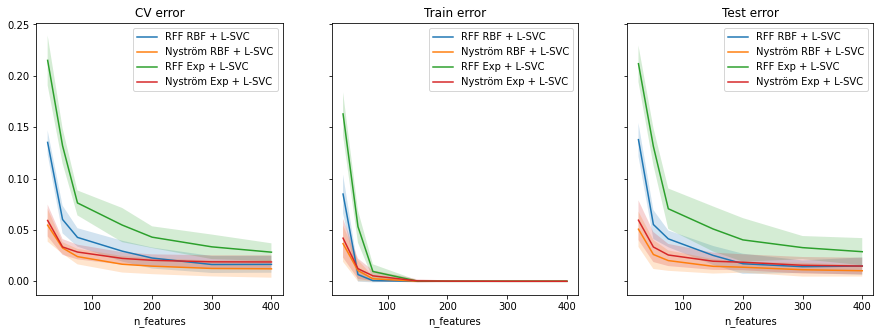

In [23]:
# Plot dependence on n_features

n_features = [25, 50, 75, 150, 200, 300, 400]

ka.plot_features_evolution(
    data,
    target,
    models,
    n_features,
    n_train=0.5,
    n_folds=5,  
    n_runs=10,
    fig_num=9,
    seed=seed
)

As we expected, the error decreases in all cases when we increase the number of features sampled, because the approximation of the kernel matrix will be better. The standard deviation of the averaged values across runs is sufficiently small, except maybe for the Random Exponential Features. We observe that around the value `n_features=200` the error in all cases is quite small, and then it starts to plateau (again, except for the Random Exponential Features).

In conclusion, the model that achieves the lowest test error with fewer number of features is the combination of Nyström RBF features and linear SVC.

---

As a final comment, we note that if we wanted to determine exactly which hyperparameters are the optimal ones for each model (available in `stats_dict['best_params']`) we would need to perform some kind of average or aggregation of the best parameters found on each of the 10 runs. This could be done, for example, choosing by majority vote, or comparing the errors on the corresponding test set and choosing the ones which produce the lowest error. However, this last approach wouldn't be entirely fair, as we would potentially be using the samples on one test set to train a different configuration of the same model on another run (the data would be contaminated, so to speak). A more detailed explanation of this *data snooping* phenomenon can be seen in (Abu-Mostafa, Magdon-Ismail and Lin, 2012, 173-178). We could avoid this situation by having yet another independent test set exclusively for making these comparisons.

## References

### Sources consulted

Rahimi, Ali, and Benjamin Recht. 2007. "Random Features for Large-Scale Kernel Machines." *NIPS*, vol. 3, no. 4, p. 5.          
[https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)       


Chang, Lo-Bin, Zhidong Bai, Su-Yun Huang, and Chii-Ruey Hwang. 2013. "Asymptotic error bounds for kernel-based Nyström low-rank approximation matrices." *Journal of Multivariate Analysis* 120: 102-119.         
[https://doi.org/10.1016/j.jmva.2013.05.006](https://doi.org/10.1016/j.jmva.2013.05.006)      


Yang, Tianbao, Yu-Feng Li, Mehrdad Mahdavi, Rong Jin, and Zhi-Hua Zhou. 2012. "Nyström method vs random fourier features: A theoretical and empirical comparison." *Advances in neural information processing systems* 25: 476-484.         
[https://homepage.cs.uiowa.edu/~tyng/papers/nystrom_random_fourier_cr.pdf](https://homepage.cs.uiowa.edu/~tyng/papers/nystrom_random_fourier_cr.pdf)         


Nguyen, Tu Dinh, Trung Le, Hung Bui, and Dinh Q. Phung. 2017. "Large-scale Online Kernel Learning with Random Feature Reparameterization." *IJCAI*: 2543-2549.       
[https://www.ijcai.org/Proceedings/2017/0354.pdf](https://www.ijcai.org/Proceedings/2017/0354.pdf)      

Hsu, Chih-Wei, Chih-Chung Chang, and Chih-Jen Lin. 2003. "A practical guide to support vector classification." 1396-1400.       
[https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)      

Abu-Mostafa, Yaser S., Malik Magdon-Ismail, and Hsuan-Tien Lin. 2012. Learning from data. Vol. 4. New York, NY, USA: AMLBook.           
[https://dl.acm.org/doi/10.5555/2207825](https://dl.acm.org/doi/10.5555/2207825)       


### Sklearn resources

1. Non-linear SVM for classification.     
[https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

2. Linear SVM for classification.     
[https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

3. Cross-validation.     
[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

4. Timing and accuracy plots for random Fourier Features and Nyström features.     
[https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html)